<a href="https://colab.research.google.com/github/tsutsumi-ozro/NLP-100knocks/blob/main/ch06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第6章: 機械学習
本章では，Fabio Gasparetti氏が公開している[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)を用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

### 50. データの入手・整形
[News Aggregator Data Set](https://archive.ics.uci.edu/ml/datasets/News+Aggregator)をダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．

1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．
2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．
3. 抽出された事例をランダムに並び替える．
4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．


学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

1

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2023-01-05 03:05:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas 100%[===================>]  27.87M  24.8MB/s    in 1.1s    

2023-01-05 03:05:14 (24.8 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
replace __MACOSX/._2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
replace __MACOSX/._newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
replace __MACOSX/._r

2, 3

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [3]:
columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=columns)

df = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
# df.query("PUBLISHER in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']")
df = df.sample(frac=1, random_state=0)

https://note.nkmk.me/python-pandas-random-sort-shuffle/

4

In [4]:
#一応u++さんがlabel encodingしているので先にしておく  -> https://upura.hatenablog.com/entry/2020/07/25/235334
use_cols = ['TITLE', 'CATEGORY']

X = df[['TITLE', 'CATEGORY']].copy()
X['CATEGORY'] = X['CATEGORY'].map({'b':0, 'e':1, 't':2, 'm':3})
y = df['CATEGORY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=0)

X_train.to_csv('./train.txt', sep='\t', index=False, header=None)
X_valid.to_csv('./valid.txt', sep='\t', index=False, header=None)
X_test.to_csv('./test.txt', sep='\t', index=False, header=None)

### 51. 特徴量抽出
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

<見た解答>
https://upura.hatenablog.com/entry/2020/07/26/000124<br>

CountVectorizer<br>
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer<br>

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction<br>

joblib.dump<br>
https://joblib.readthedocs.io/en/latest/generated/joblib.dump.html

In [5]:
import joblib
#CountVectorizer -> token数の行列に変換する
from sklearn.feature_extraction.text import CountVectorizer
X_train['TMP'] = 'train'
X_test['TMP'] = 'test'
X_valid['TMP'] = 'valid'

data = pd.concat([X_train, X_valid, X_test]).reset_index(drop=True)
# このtoken_patternは何？
vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
bag = vectorizer.fit_transform(data['TITLE'])
data = pd.concat([data, pd.DataFrame(bag.toarray())], axis=1)

joblib.dump(vectorizer.vocabulary_, 'vocabulary_.joblib')

X_train_feature = data.query('TMP=="train"').drop(use_cols+['TMP'], axis=1)
X_valid_feature = data.query('TMP=="valid"').drop(use_cols+['TMP'], axis=1)
X_test_feature = data.query('TMP=="test"').drop(use_cols+['TMP'], axis=1)

X_train_feature.to_csv('./train.feature.txt', sep='\t', index=False, header=None)
X_valid_feature.to_csv('./valid.feature.txt', sep='\t', index=False, header=None)
X_test_feature.to_csv('./test.feature.txt', sep='\t', index=False, header=None)

### 52. 学習
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [12]:
from sklearn.linear_model import LogisticRegression
X_train = pd.read_table('/content/train.feature.txt', header=None)
y_train = pd.read_table('/content/train.txt', header=None)
y_train = y_train[1]

#documentで他クラス分類は'sag'が推奨されている
clf = LogisticRegression(solver='sag', random_state=0)
clf.fit(X_train, y_train)
#とりあえず後々使うかもしれないから保存しておこうの精神を身につける
joblib.dump(clf, 'model.joblib')

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['model.joblib']

### 53. 予測
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [13]:
predict_y_train = clf.predict(X_train)

In [14]:
predict_y_train

array([0, 0, 1, ..., 0, 0, 1])

### 54. 正解率の計測
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [17]:
from sklearn.metrics import accuracy_score
X_test = pd.read_table('/content/test.feature.txt', header=None)
y_test = pd.read_table('/content/test.txt', header=None)[1]

print(f'学習データでの正解率: {accuracy_score(y_train, clf.predict(X_train))}')
print(f'評価データでの正解率: {accuracy_score(y_test, clf.predict(X_test))}')

学習データでの正解率: 0.9641116941529235
評価データでの正解率: 0.9055472263868066


### 55. 混同行列の作成
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix

In [19]:
#多分類だと見づらい
from sklearn.metrics import confusion_matrix
print(f'学習データのconfusion matrix: \n {confusion_matrix(y_train, clf.predict(X_train))}')
print(f'評価データのconfusion matrix: \n {confusion_matrix(y_test, clf.predict(X_test))}')

学習データのconfusion matrix: 
 [[4412   37   43   10]
 [  18 4196    9    0]
 [ 100   59 1057    3]
 [  48   47    9  624]]
評価データのconfusion matrix: 
 [[527  18  16   2]
 [ 10 515   2   1]
 [ 34  16 100   2]
 [  8  13   4  66]]


### 56. 適合率，再現率，F1スコアの計測
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

各スコアのdocument参照

In [20]:
from sklearn.metrics import recall_score, precision_score, f1_score
y_test_pred = clf.predict(X_test)
#defaultだとaverage='binary'なのでNoneにしないと
print(f'評価データのrecall　score: {recall_score(y_test, y_test_pred, average=None)}')
print(f'評価データのrecall　score micro: {recall_score(y_test, y_test_pred, average="micro")}')
print(f'評価データのrecall score macro: {recall_score(y_test, y_test_pred, average="macro")}', "\n")

print(f'評価データのprecision_score: {precision_score(y_test, y_test_pred, average=None)}')
print(f'評価データのprecision_score micro: {precision_score(y_test, y_test_pred, average="micro")}')
print(f'評価データのprecision_score macro: {precision_score(y_test, y_test_pred, average="macro")}', "\n")

print(f'評価データのf1_score: {f1_score(y_test, y_test_pred, average=None)}')
print(f'評価データのf1_score micro: {f1_score(y_test, y_test_pred, average="micro")}')
print(f'評価データのf1_score macro: {f1_score(y_test, y_test_pred, average="macro")}', "\n")

評価データのrecall　score: [0.93605684 0.97537879 0.65789474 0.72527473]
評価データのrecall　score micro: 0.9055472263868066
評価データのrecall score macro: 0.8236512720903788 

評価データのprecision_score: [0.91018998 0.91637011 0.81967213 0.92957746]
評価データのprecision_score micro: 0.9055472263868066
評価データのprecision_score macro: 0.8939524213566705 

評価データのf1_score: [0.92294221 0.94495413 0.72992701 0.81481481]
評価データのf1_score micro: 0.9055472263868066
評価データのf1_score macro: 0.8531595393023608 



### 57. 特徴量の重みの確認
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

重みとwordを紐づけたかったのでu++さんのコードをお借りします<br>
https://upura.hatenablog.com/entry/2020/07/26/002131

In [26]:
coefs = clf.coef_
vocabulary_ = joblib.load('/content/vocabulary_.joblib')
# coefs.shape->(4, 14076)
for c in coefs:
    d = dict(zip(vocabulary_, c))
    d_top = sorted(d.items(), key=lambda x: abs(x[1]), reverse=True)[:10]
    print(d_top)
    d_bottom = sorted(d.items(), key=lambda x: abs(x[1]), reverse=False)[:10]
    print(d_bottom, '\n')

[('pull', 1.729145759909519), ('bribery', 1.6634543603584073), ('unacceptable', 1.5425781317521086), ('number', 1.3583162149494201), ('reasserts', 1.3567463307636314), ('continues', 1.3559461527001508), ('subside', 1.3260789401513786), ('northern', 1.2808537315526731), ('wgc', 1.2593669248050798), ('wedge', 1.2092808113084395)]
[('airlines', 0.0), ('subdued', 0.0), ('slightly', 0.0), ('cyrus', 0.0), ('solange', 0.0), ('5', 0.0), ('bln', 0.0), ('buy', 0.0), ('alstom', 0.0), ('from', 0.0)] 

[('experiencing', 1.530284518181774), ('winning', 1.4011413274798528), ('cavemen', -1.3936765138759841), ('affiliate', 1.1970518724511539), ('garth', 1.1769687610891209), ('gamblers', 1.1694855635470447), ('mobility', 1.165992180023414), ('targeted', 1.1590089341988732), ('number', -1.1497960179610358), ('69000', -1.1383569726346183)]
[('airlines', 0.0), ('subdued', 0.0), ('slightly', 0.0), ('cyrus', 0.0), ('solange', 0.0), ('5', 0.0), ('bln', 0.0), ('buy', 0.0), ('alstom', 0.0), ('from', 0.0)] 

[('

### 58. 正則化パラメータの変更
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

X_train = pd.read_table('./train.feature.txt', header=None)
X_valid = pd.read_table('./valid.feature.txt', header=None)
X_test = pd.read_table('./test.feature.txt', header=None)
y_train = pd.read_table('./train.txt', header=None)[1]
y_valid = pd.read_table('./valid.txt', header=None)[1]
y_test = pd.read_table('./test.txt', header=None)[1]

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


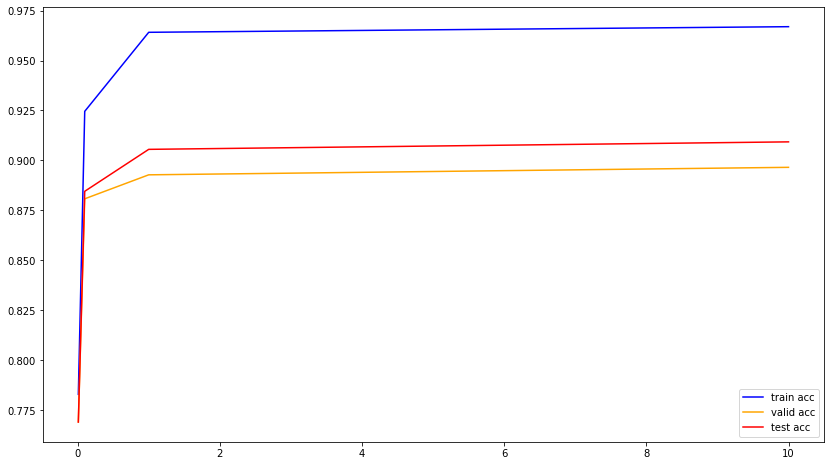

<Figure size 432x288 with 0 Axes>

In [29]:
C_list = [0.01, 0.1, 1.0, 10]
train_acc = []
valid_acc = []
test_acc = []

for c in C_list:
    clf = LogisticRegression(solver='sag', random_state=0, C=c)
    clf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, clf.predict(X_train)))
    valid_acc.append(accuracy_score(y_valid, clf.predict(X_valid)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.figure(figsize=(14, 8))
plt.plot(C_list, train_acc, label='train acc', color='blue')
plt.plot(C_list, valid_acc, label='valid acc', color='orange')
plt.plot(C_list, test_acc, label='test acc', color='red')
plt.legend()
plt.show()
plt.savefig('./ans58.png')

### 59. ハイパーパラメータの探索
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [30]:
# ロジスティック回帰
print(f'ロジスティック回帰でのmax accuracy socre: {max(test_acc)}', '\n')
print(f'その際の正則化パラメータ: {C_list[test_acc.index(max(test_acc))]}', '\n')

ロジスティック回帰でのmax accuracy socre: 0.9092953523238381 

その際の正則化パラメータ: 10 



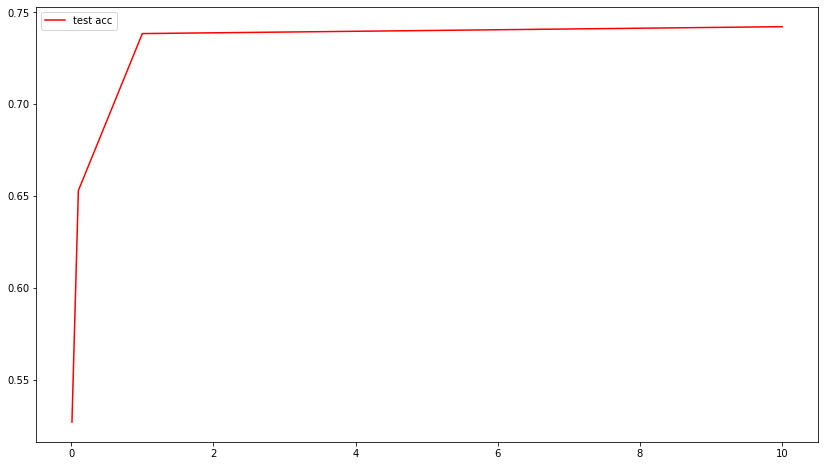

ランダムフォレストでのmax accuracy socre: 0.7421289355322339 

その際のmax_depthパラメータ: 16 



<Figure size 432x288 with 0 Axes>

In [31]:
# ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
max_depth_list = [2, 4, 8, 16]
test_acc = []
for m in max_depth_list:
    clf = RandomForestClassifier(max_depth=m, random_state=0)
    clf.fit(X_train, y_train)
    test_acc.append(accuracy_score(y_test, clf.predict(X_test)))
plt.figure(figsize=(14, 8))
plt.plot(C_list, test_acc, label='test acc', color='red')
plt.legend()
plt.show()
plt.savefig('./59_RomdomForest.png')

print(f'ランダムフォレストでのmax accuracy socre: {max(test_acc)}', '\n')
print(f'その際のmax_depthパラメータ: {max_depth_list[test_acc.index(max(test_acc))]}', '\n')